### Approximating sin(x) over range (-PI, PI)

Say we have a linear regression problem where domain of the
function we are tying to fit is [-10 to 10]
and value of label y is sin(x).

#### Maclaurin Expansion of sin(x) is given by (this is an infinite series, but we are considering only a few terms)
$ sin(x) = x - x^{3}/{3!} + x^{5}/{5!} - x^{7}/{7!}$  

which basically is  

$ sin(x) = x - 0.1666*x^{3} + 0.00833333*x^{5} - 0.0001984126*x^{7}$  
#### Can we try to fit below function and expect to get a,c,e and g close to 0 and b,d,f,h close to 1, -0.1666, 0.008333, -0.0001984126 respectively?
$ a+bx+cx^{2}+dx^{3}+ex^{4}+fx^{5}+gx^{6}+hx^{7}$  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yodf as tf
import time
%matplotlib inline

(8, 1)


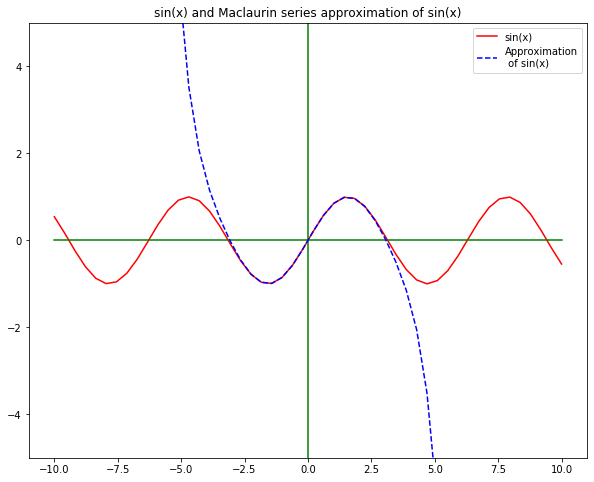

In [2]:
# data points, m = 50
X = np.linspace(-10,10)
m = X.shape[0]
X = X.reshape(m, 1)
y = np.sin(X)

def approximate_sin(X):
    return X-0.16666*np.power(X,3)+0.0083333*np.power(X,5)-0.0001984126*np.power(X,7)

W = np.array([[0., 1., 0., -0.1666, 0., 0.0083333, 0., -0.0001984126]]).T
print(W.shape)
plt.figure(figsize=(10,8))
axes = plt.gca()
axes.set_ylim([-5,5])
plt.title('sin(x) and Maclaurin series approximation of sin(x)')
plt.plot(X, y, color='red', label='sin(x)')
plt.plot(X, np.zeros((m,1)), color='g')
plt.plot(np.zeros((m,1)), np.linspace(-5,5), color='g')
plt.plot(X, approximate_sin(X), color='blue', linestyle='dashed', label='Approximation\n of sin(x)')
plt.legend(loc="upper right")

In [3]:
## As can be seen above, using just 4 terms of Maclaurin seris for sin(x),
## we get approximate curve which over the range of -PI to PI is
## pretty close to sin(x) curve

In [4]:
def add_features(X, n=7):    
    _X = np.copy(X)
    for i in range(2, n+1):
        _X = np.hstack((_X, np.power(_X[:,0:1], i)))
    return _X

def normalize(X, means=None, stds=None):
    n = X.shape[1]
    if means is None:
        means = np.mean(X, 0).reshape(1, n)
        stds = np.std(X, 0).reshape(1, n)
    return (X-means)/stds, means, stds

Execution Time: 2.258 seconds.
Execution Time: 4.330 seconds.
Execution Time: 6.358 seconds.


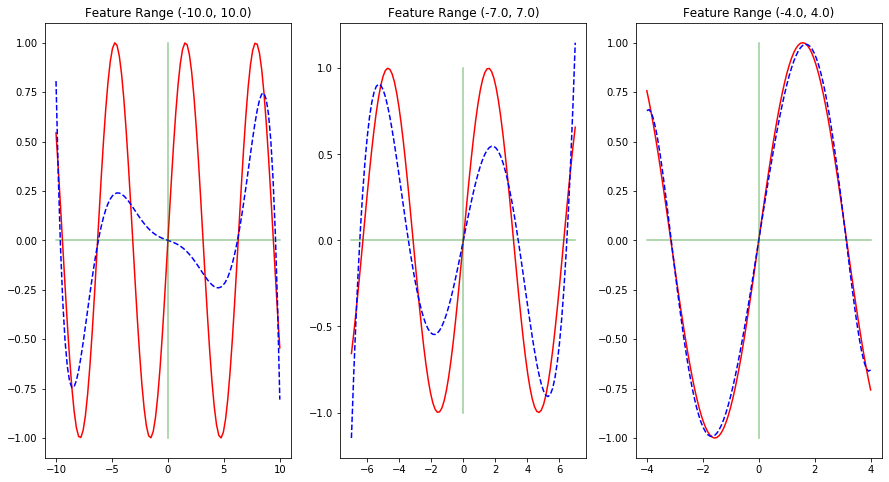

In [5]:
X_ranges = [np.linspace(-10.,10., 100), np.linspace(-7,7, 100), np.linspace(-4,4, 100)]

plt.figure(figsize=(15,8))
for i in range(len(X_ranges)):
    X = X_ranges[i]
    m = X.shape[0]
    X = X.reshape(m, 1)
    y = np.sin(X)
    
    X_n = add_features(X)
    # Normalization is a must as we are adding high order features
    X_n, means, stds = normalize(X_n)
    X_n = np.hstack((np.ones((X.shape[0], 1)), X_n))
    
    start_time = time.time()
    # Curve fitting using Tensorflow
    W = tf.Variable(np.zeros((X_n.shape[1], 1)))
    y_predicted = tf.matmul(X_n, W)
    cost_function = 1./(2.*m)*tf.reduce_sum(tf.square(tf.subtract(y_predicted, y)))

    train = tf.train.GradientDescentOptimizer(learning_rate=0.35).minimize(cost_function)
    init = tf.global_variables_initializer()

    iterations = 5000
    costs = []
    with tf.Session() as s:
        s.run(init)
        for j in range(iterations):
            cost, W_final, _ = s.run([cost_function, W, train])
            if j%100 == 0:
                costs.append(cost)
    end_time = time.time()
    print(f"Execution Time: {end_time-start_time:0.3f} seconds.")

    plt.subplot(1,3,i+1)
    plt.title(f"Feature Range {np.min(X),  np.max(X)}")
    # sin(x)
    plt.plot(X, y, color='red', label='sin(x)')
    # fitted curve
    plt.plot(X, np.dot(X_n, W_final), color='blue', linestyle='dashed')
    # X and Y axes respectively
    plt.plot(X, np.zeros((m,1)), color='g', alpha=0.4)
    plt.plot(np.zeros((m,1)), np.linspace(-1,1,m), color='g', alpha=0.4)

In [6]:
# Quite clearly, Gradient descent does a much better job as you narrow down on range of X
# We set out to find approximation of sin(x) only over the range of -PI to PI
# So if we try to fit a curve for the range say (-10, 10), cost function is
# trying to minimize cost for all the X and not only for the X in the range (-PI, PI)

In [7]:
print(W_final.T)

[[-1.10137593e-16  2.08846173e+00  3.22118214e-16 -2.76769914e+00
  -3.18812075e-16  2.37593263e-01 -1.92236282e-16  5.86216963e-01]]


If we call above weights as a,b,c,d,e,f and g indeed a,c,e and g are almost zero. b, d, e and g are not quite close to 1, -0.1666, 0.008333 and -0.0001984126 respectively. But that's to be expected as   
- We did model fitting after scaling the features
- As can be seen in the plot below, $ x - 0.1666*x^{3} + 0.00833333*x^{5} - 0.0001984126*x^{7}$  actually diverges to +INFINITY and -INFINITY immediately and fits sin(x) only in the range -PI to PI whereas our fitted curve does a slightly better job of fitting sin(x) over range (-10, 10). Of course, the weights used below are the ones when model was trained with X range (-4, 4). You will see it doing an even better overall job of matching sin(x) over range (-10, 10) if you use weights trained with X range (-10, 10)

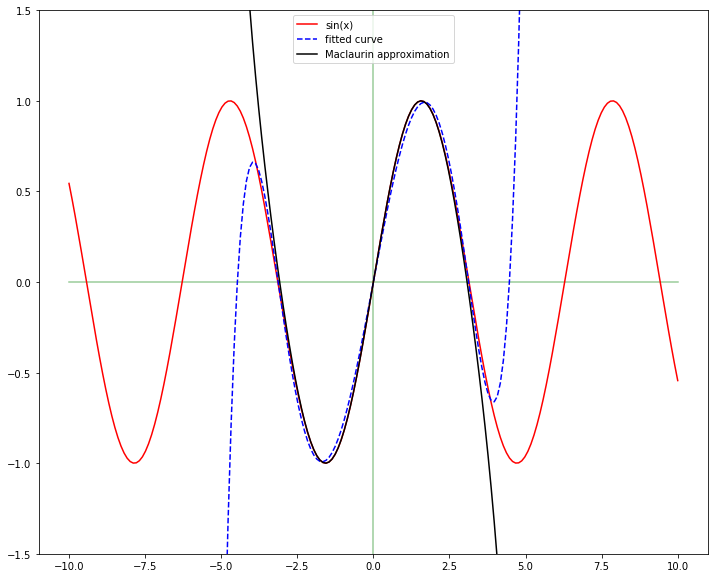

In [8]:
plt.figure(figsize=(12,10))
X = np.linspace(-10, 10, 200)
m = X.shape[0]
X = X.reshape(m, 1)
y = np.sin(X)

X_n = add_features(X)
X_n, _, _ = normalize(X_n, means, stds)
X_n = np.hstack((np.ones((X.shape[0], 1)), X_n))
plt.axes().set_ylim([-1.5,1.5])
plt.plot(X, np.zeros((m,1)), color='g', alpha=0.4)
plt.plot(np.zeros((m,1)), np.linspace(-1.5,1.5,m), color='g', alpha=0.4)
plt.plot(X, np.sin(X), color='r', label='sin(x)')
plt.plot(X, np.dot(X_n, W_final), color='blue', linestyle='dashed', label='fitted curve')
plt.plot(X, approximate_sin(X), color='black', label='Maclaurin approximation')
plt.legend(loc="upper center")